In [2]:
import numpy as np
import pandas as pd
from pathlib import Path
from skimage.io import imread
from skimage.io import imsave
from scipy.spatial import KDTree
BASE_DIR = Path('/mnt/data/local_processed_data')
RUN_ID = '20220106_Normal2_redo_overnight'
src_dir = BASE_DIR / f'{RUN_ID}_processed'
stc_dir = src_dir / 'stitched'
read_dir = src_dir / 'readout'
seg_dir = src_dir / 'segmented'
visual_dir = src_dir / 'visualization'
visual_dir.mkdir(exist_ok=True)

In [3]:
# Read nucleus position
centroids = pd.read_csv(seg_dir/'centroids_all.csv', header=None).to_numpy()

In [4]:
# Assign RNA to its nearest nucleus
rna_df = pd.read_csv(read_dir/'mapped_genes.csv')
rna_pos = rna_df[['Y', 'X']].to_numpy()
tree = KDTree(centroids)
distances, indices = tree.query(rna_pos, k=1, distance_upper_bound=100)
rna_df['Cell Index'] = indices
rna_df = rna_df[rna_df['Cell Index'] < centroids.shape[0]]
#rna_df.to_csv(visual_dir/'rna_labeled.csv',index=False)
rna_df

,Y,X,Gene,Cell Index
0,108,24397,Actb,0
1,116,24390,Actb,0
2,117,24392,Penk,0
3,121,24385,Actb,0
4,123,24390,Aqp4,0
...,...,...,...,...
16606768,46793,29042,Olig1,146150
16606769,46793,29043,Olig1,146150
16606770,46793,29095,Actb,146151
16606771,46793,29100,Actb,146151


In [8]:
# Generate expression matrix
match_df = rna_df.copy()
match_df['Count'] = np.ones(len(match_df))
match_df_group = match_df[['Cell Index','Gene','Count']].groupby(['Cell Index','Gene']).count()
matrix = match_df_group.unstack().fillna(0)
matrix.columns = matrix.columns.droplevel()
matrix.columns.name = None
matrix.index.name = None
#matrix.to_csv(visual_dir/'expression_matrix.csv')
matrix

,Actb,Adarb2,Apoc1,Apod,Apoe,App,App_human,Aqp4,B2m,BEX1,...,Synpr,Tgfbr2,Tmem119,Trem2,Trf,Tyrobp,Vim,Vip,Vxn,Wfs1
0,10.0,2.0,0.0,2.0,2.0,0.0,0.0,2.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,2.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,4.0,5.0,0.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
146146,2.0,5.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
146147,3.0,8.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
146148,1.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
146150,7.0,2.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0


In [9]:
# Mask restoration
matrix[['Actb']] *=5
matrix[['Slc17a7']] *=2
matrix[['Sst']] *=10
matrix[['Snap25']] *=3
matrix[['Cst3']] *=3
matrix[['Mbp']] *=3
matrix[['Penk']] *=4
# Filter by Actb counts
matrix = matrix[matrix['Actb']>=20]
matrix

,Actb,Adarb2,Apoc1,Apod,Apoe,App,App_human,Aqp4,B2m,BEX1,...,Synpr,Tgfbr2,Tmem119,Trem2,Trf,Tyrobp,Vim,Vip,Vxn,Wfs1
0,50.0,2.0,0.0,2.0,2.0,0.0,0.0,2.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,20.0,5.0,0.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,50.0,0.0,0.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,20.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11,115.0,1.0,0.0,1.0,1.0,0.0,0.0,3.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
146139,20.0,3.0,0.0,1.0,5.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
146143,25.0,3.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
146145,25.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
146150,35.0,2.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0


In [20]:
# General cell typing
matrix['Cell_Index'] = matrix.index
matrix['General Type'] = 'Non neuonal cell'
matrix['Cluster'] = 0
matrix.loc[(matrix['Slc17a7']>0),'General Type'] = 'Excite' 
matrix.loc[(matrix['Slc17a7']>0),'Cluster'] = 1 
matrix.loc[(matrix['Gad1']+matrix['Gad2']>4),'General Type'] = 'Inhibit' 
matrix.loc[(matrix['Gad1']+matrix['Gad2']>4),'Cluster'] = 2 
matrix
# A finer classification could be performed by leiden clustering within each general type

/tmp/ipykernel_2549756/2582776133.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  matrix['Cell_Index'] = matrix.index
/tmp/ipykernel_2549756/2582776133.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  matrix['General Type'] = 'Non neuonal cell'
/tmp/ipykernel_2549756/2582776133.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-

,Actb,Adarb2,Apoc1,Apod,Apoe,App,App_human,Aqp4,B2m,BEX1,...,Trem2,Trf,Tyrobp,Vim,Vip,Vxn,Wfs1,General Type,Cell_Index,Cluster
0,50.0,2.0,0.0,2.0,2.0,0.0,0.0,2.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,Non neuonal cell,0,0
2,20.0,5.0,0.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Non neuonal cell,2,0
5,50.0,0.0,0.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Non neuonal cell,5,0
8,20.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Non neuonal cell,8,0
11,115.0,1.0,0.0,1.0,1.0,0.0,0.0,3.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Non neuonal cell,11,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
146139,20.0,3.0,0.0,1.0,5.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Non neuonal cell,146139,0
146143,25.0,3.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Non neuonal cell,146143,0
146145,25.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Excite,146145,1
146150,35.0,2.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,2.0,0.0,Non neuonal cell,146150,0


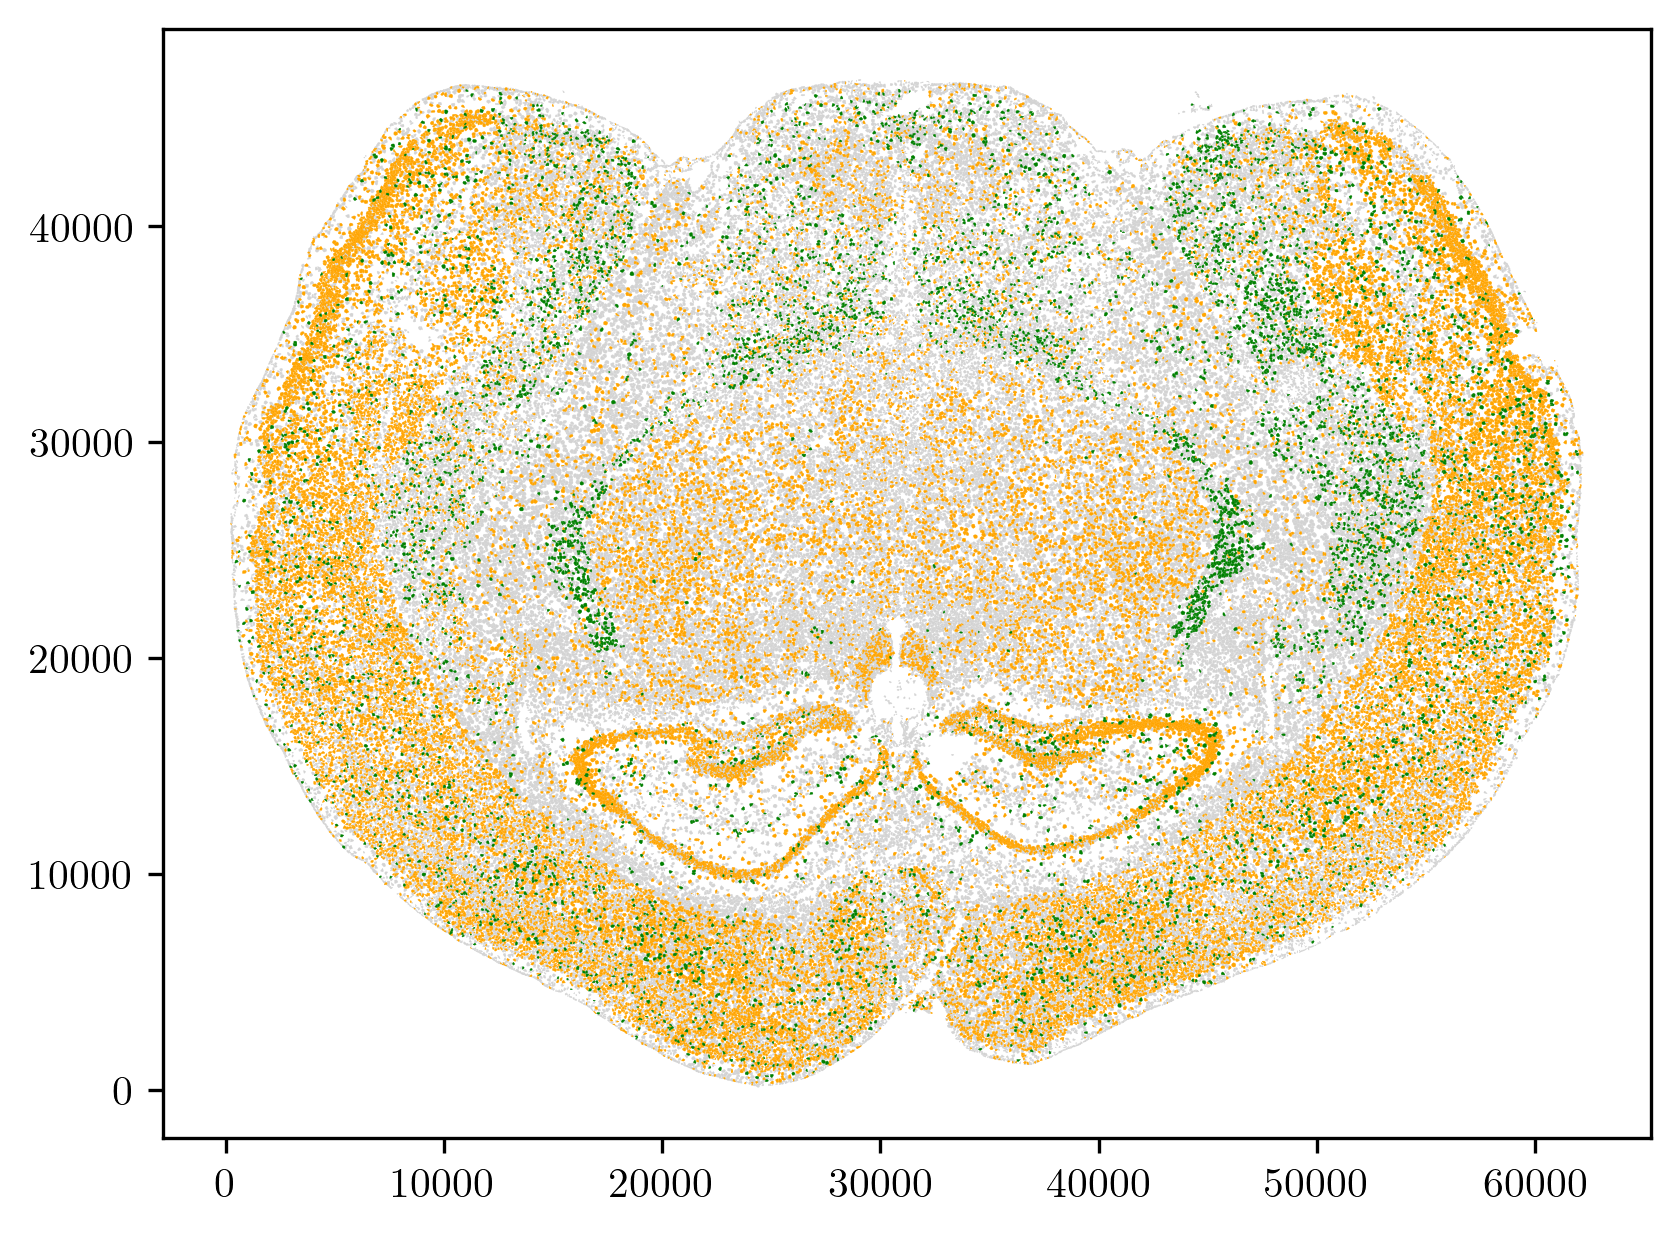

In [24]:
# Draw projection
from scipy.spatial import ConvexHull
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
#plt.style.use('dark_background')
plt.style.use('default')
from matplotlib.colors import ListedColormap
from scipy.interpolate import splprep
from scipy.interpolate import splev
from scipy.spatial.qhull import QhullError
matplotlib.rcParams.update({
"pgf.texsystem": "xelatex",
'font.family': 'serif',
'text.usetex': True,
'pgf.rcfonts': False,
'figure.dpi': 300,
})

factor = matrix[['Cell_Index','Cluster']]
type_indices = {}
for type in range(len(np.unique(factor['Cluster']))):
    type_indices[type] = list(factor[factor['Cluster']==type]['Cell_Index'])

x = 0.1
y = 1
df = rna_df
hulls = {}
df_group = df.groupby('Cell Index')
for group in df_group:
    coordinates = group[1][['Y', 'X']].values   
    try:
        hull = ConvexHull(coordinates)
        coordinate_path = np.vstack((coordinates[hull.vertices,0], coordinates[hull.vertices,1])).T
        hulls[group[0]] = coordinate_path
    except QhullError:
        pass

fig,ax = plt.subplots() 
figsize=(6.2,4.7)
for idx in type_indices[0]:
    try:
        ax.fill(hulls[idx][:,1], hulls[idx][:,0], color = "lightgray", linewidth=x, alpha=y)
    except KeyError:
        pass
for idx in type_indices[1]:
    try:
        ax.fill(hulls[idx][:,1], hulls[idx][:,0], color = "orange", linewidth=x, alpha=y)
    except KeyError:
        pass
for idx in type_indices[2]:
    try:
        ax.fill(hulls[idx][:,1], hulls[idx][:,0], color = "green", linewidth=x, alpha=y)
    except KeyError:
        pass
plt.show()
#plt.close()